In [11]:
!unzip data.zip -d .

Archive:  data.zip
replace ./Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Project COSC 6324**

Objective: Develop a system for classifying objects within RGB images

## 1. Import Libraries and Dataset

### Import Required Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [31]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


### Load Dataset

In [32]:
data = pd.read_csv('Data.csv')
labels = pd.read_csv('classLabel.csv')
print(data.shape)

(9999, 3072)


In [34]:
data

,59,43,50,68,98,119,139,145,149,149.1,...,59.21,58.21,65.19,59.22,46.22,57.27,104.16,140.19,84.21,72.15
0,154,126,105,102,125,155,172,180,142,111,...,22,42,67,101,122,133,136,139,142,144
1,255,253,253,253,253,253,253,253,253,253,...,78,83,80,69,66,72,79,83,83,84
2,28,37,38,42,44,40,40,24,32,43,...,53,39,59,42,44,48,38,28,37,46
3,170,168,177,183,181,177,181,184,189,189,...,92,88,85,82,83,79,78,82,78,80
4,159,150,153,154,138,184,154,77,61,64,...,15,18,16,12,13,16,14,14,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,18,18,21,23,24,23,24,25,22,19,...,20,24,33,41,45,39,39,39,34,37
9995,235,240,249,253,254,253,254,254,179,108,...,75,89,113,139,163,174,179,182,181,181
9996,71,60,74,73,87,125,179,231,250,252,...,71,70,67,66,70,81,78,68,69,68
9997,250,254,211,64,61,60,55,54,55,59,...,134,134,132,130,127,132,133,215,255,254


In [35]:
labels

,6
0,9
1,9
2,4
3,1
4,1
...,...
9994,3
9995,9
9996,1
9997,1


## 2. Data Preprocessing and Visualization
### Plot Label Frequencies


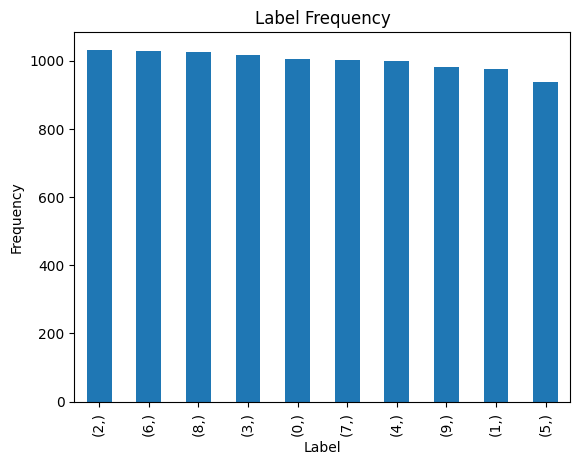

6
2    1032
6    1029
8    1025
3    1016
0    1005
7    1001
4     999
9     981
1     974
5     937
Name: count, dtype: int64


In [38]:

label_freq = labels[0:].value_counts()

label_freq.plot(kind='bar',
                title='Label Frequency',
                xlabel='Label',
                ylabel='Frequency')
plt.show()
print(label_freq)


### Convert RGB Images to Grayscale

In [39]:

# Initialize an empty list to store the grayscale images
grayscale_images = []

for i in range(len(data)):
    row = data.iloc[i]

    rgb_image = np.array(row).reshape(32, 32, 3)

    grayscale_image = np.dot(
        rgb_image[..., :3],
        [0.2989, 0.5870, 0.1140])  # Convert to grayscale using weighted sum
    grayscale_images.append(grayscale_image)

grayscale_images = np.array(grayscale_images)


### Split Data into Training and Testing Sets
### Convert Data to Tensors and Create DataLoaders


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(grayscale_images,
                                   test_size=0.3,
                                   random_state=20)
Y_train, Y_test = train_test_split(labels, test_size=0.3, random_state=20)

# Convert X_train and X_test to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

# Convert Y_train and Y_test to tensors
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

# Create a DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


## 3. Construct the Convolutional Neural Network (CNN)

### Define the CNN Structure

1. **Feature Extraction**
    - **Input Layer Neurons**: The input layer processes a single-channel image, with the number of neurons equal to the number of pixels in the image.
    - **Convolutional and Pooling Layers**: The network includes 5 convolutional layers, each followed by a max-pooling layer.
    - **Feature Maps**: The final max-pooling layer generates 512 feature maps before the fully connected layers.

2. **Classification**
    - **Neurons in Classification Input Layer**: The input layer for classification comprises 512 neurons.
    - **Classification Layers**: The network has 2 fully connected layers dedicated to classification.
    - **Output Layer Neurons**: The output layer features 10 neurons, corresponding to the 10 classification categories.

In [46]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(512, 512)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = x.squeeze()
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.fc2(x)
        return x


## 4. Training the Model

### Initialize Model, Loss Function, and Optimizer


In [47]:

model = CNN().to(device)  # Move the model to GPU

criterion = nn.CrossEntropyLoss()  # Defining the loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Defining the optimizer


**Loss Function Used:**

The loss function utilized for this classification task is Cross-Entropy Loss. This function is widely adopted for multi-class classification problems. It evaluates the performance of a classification model by comparing the predicted probabilities with the actual target labels. In PyTorch, `torch.nn.CrossEntropyLoss` integrates both the LogSoftmax and Negative Log Likelihood Loss (NLLLoss) functions into a single class, providing a combined measure of model accuracy.

### Train the Model


In [48]:

import torch

# Train the model
train_loss = []
grad_norm = float('inf')  # Initialize with a large value
best_epoch = 0
threshold = 1e-4  # Set your desired threshold for the gradient norm

num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.squeeze()  # Reduce the dimension of labels
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1} Loss: {train_loss[-1]}")

    # Compute the gradient norm and check for the stopping criterion
    new_grad_norm = torch.norm(
        torch.stack([torch.norm(param.grad) for param in model.parameters()]),
        2.0)

    if new_grad_norm < threshold:
        print(f"Stopping at epoch {epoch+1} due to small gradient norm.")
        break

    if new_grad_norm < grad_norm:
        best_epoch = epoch
        grad_norm = new_grad_norm

print("Training completed!")

train_loss = pd.DataFrame(train_loss)
print("Train Loss:")
train_loss.head(10)
print("Best epoch: ", max(train_loss.index)+1)
# print(train_loss)


Epoch 1 Loss: 2.317625074271458
Epoch 2 Loss: 2.305873242262892
Epoch 3 Loss: 2.304326827627605
Epoch 4 Loss: 2.3031800539940828
Epoch 5 Loss: 2.3033393925642147
Epoch 6 Loss: 2.3084926611526573
Epoch 7 Loss: 2.303191874023505
Epoch 8 Loss: 2.3030397191288166
Epoch 9 Loss: 2.302805345932881
Epoch 10 Loss: 2.3030230694114184
Training completed!
Train Loss:
Best epoch:  10


### Plot Training Loss


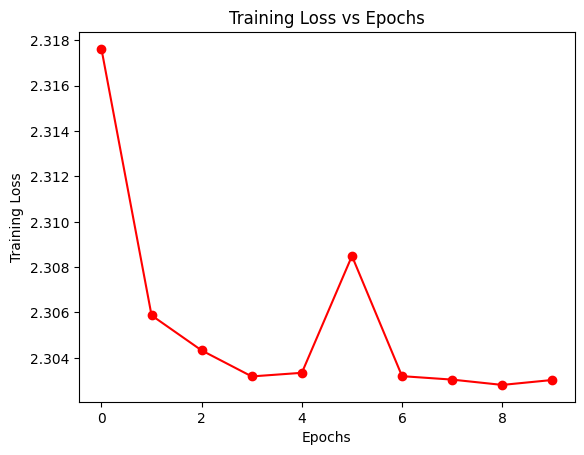

In [49]:

import matplotlib.pyplot as plt

plt.plot(train_loss, color='red', label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.show()


## 5. Testing the Model

### Evaluate Test Accuracy

In [50]:
model.eval()  # evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        # print(outputs.argmax(),labels.squeeze())
        predicted = outputs.argmax()
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

accuracy = (correct / total) * 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 9.77%
